In [3]:
import torch.nn as nn
from torchvision.datasets.folder import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
from statistics import mean
import impaintingLib as imp
import numpy as np
import matplotlib.pyplot as plt

import torchvision
from mpl_toolkits.axes_grid1 import ImageGrid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
discriminator = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        ).to(device)

In [5]:
import impaintingLib as imp
classif = imp.loss.getTrainedModel()

def simplifyChannels(x):
    x = np.where(x == 3, 0, x) 
    x = np.where(x == 4, 3, x) 
    x = np.where(x == 5, 3, x) 
    x = np.where(x == 6, 4, x) 
    x = np.where(x == 7, 4, x) 
    x = np.where(x == 8, 5, x) 
    x = np.where(x == 9, 5, x) 
    x = np.where(x == 10 , 6, x) 
    x = np.where(x == 11, 7, x) 
    x = np.where(x == 12, 7, x)  
    x = np.where(x > 12, 0, x)
    return x

def npToTensor(x):
    c,w,h = x.shape
    x = torch.from_numpy(x).to(device)
    x = torch.reshape(x, (c,1,w,h))
    return x.float()

def get_segmentation(x, segmenter=classif, scale_factor=4, simplify=True):
    n,c,w,h = x.shape
    with torch.no_grad():
        if scale_factor > 0 :
            x = torch.nn.functional.interpolate(x, scale_factor=scale_factor)
        x = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(x)
        y = classif(x)
        if scale_factor > 0 :
            y = torch.nn.functional.avg_pool2d(y, scale_factor)
            
    y = imp.loss.generate_label_plain(y,w)
    if simplify: 
        y = simplifyChannels(y)
    y =  (y / (np.amax(y)+2)) + 0.1
    y = npToTensor(y)
    return y

In [6]:
def plot_img(x,title=""):
    img_grid = make_grid(x[:16])
    plt.figure(figsize=(20,15))
    plt.imshow(img_grid.cpu().permute(1, 2, 0))
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()
    
def getTestData(file,factorResize=1):
    resize = (120*factorResize, 120*factorResize)
    crop   = (64*factorResize, 64*factorResize)
    process = transforms.Compose([
         transforms.Resize(resize), 
         transforms.CenterCrop(crop),
         transforms.ToTensor()
    ])
    return ImageFolder(file, process)

In [7]:
def update_discriminator(discriminator, optimizer, x, fake, real_label=0.9, fake_label=0):
    discriminator.zero_grad()
    b_size = x.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    # Forward pass real batch through D
    output = discriminator(x).view(-1)
    # Calculate loss on all-real batch
    loss = nn.BCELoss()(output, label)
    D_x = output.mean().item()
    label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
    # Classify all fake batch with D
    output = discriminator(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    loss += nn.BCELoss()(output, label) 
    D_G_z1 = output.mean().item()
    loss.backward()
    optimizer.step()
    return loss, D_x, D_G_z1

def update_generatot(generator, discriminator, optimizer, x, fake, real_label=0.9):
    generator.zero_grad()
    b_size = fake.size(0)   
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    output = discriminator(fake).view(-1)
    
    loss = torch.nn.L1Loss()(fake, x) 
    loss += imp.loss.perceptualVGG(fake, x) 
    loss += imp.loss.totalVariation(fake, x)
    loss += nn.BCELoss()(output, label)
    
    loss.backward()
    D_G_z2 = output.mean().item()
    optimizer.step()
    return loss, D_G_z2

In [8]:
def train_context_encoder(generator, discriminator, optimizerG, optimizerD, loader, alter, epochs=10, scale_factor=4, real_label=0.9, fake_label=0, show_images=True):
    for epoch in range(epochs):
        t = tqdm(loader)
        for x, _ in t:
            x = x.to(device)
            ## Train with all-fake batch
            segmented = get_segmentation(x, simplify=True, scale_factor=scale_factor)
            x_prime = alter(x)
            x_input = torch.cat((x_prime, segmented),dim=1)
            fake = generator(x_input)

        # discriminator update
            errD, D_x, D_G_z1 = update_discriminator(discriminator, optimizerD, x, fake, real_label, fake_label)
            errG, D_G_z2 = update_generatot(generator, discriminator, optimizerG, x, fake, real_label)


        print(f'epoch:{epoch}/{epochs} \tLoss_D:{errD.item():.4f} \tLoss_G:{errG.item():.4f} \tD(x):{D_x:.4f} \tD(G(z)):{D_G_z1:.4f} / {D_G_z2:.4f}')
        if show_images:
            plot_img(x[:8])
            plot_img(x_prime[:8])
            plot_img(segmented[:8])
            plot_img(torch.clip(fake[:8], 0, 1))
            
def test_results_sample(net, testloader, alter, simplify_seg=True, min_cut=15,max_cut=45, scale_factor=4,title=""):
    with torch.no_grad():
        x, _ = next(iter(testloader))
        x = x.to(device)
        segmented = get_segmentation(x, simplify=simplify_seg, scale_factor=scale_factor)
        x_prime = alter(x)
        x_input = torch.cat((x_prime, segmented),dim=1)
        outputs = net(x_input)
        #plot_img(x[:8])
        #plot_img(x_prime[:8])
        #plot_img(segmented[:8])
        plot_img(torch.clip(outputs[:8], 0, 1),title=title)

In [24]:
real_label = 0.9
fake_label = 0.

discriminator.apply(weights_init);
generator = imp.model.UNet(4, netType="partial").to(device) 
generator.load_state_dict(torch.load("./modelSave/09_08/partial4channels_low"))
generator.eval()

# Setup Adam optimizers for both G and D
lr = 0.002
beta1 = 0.5
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr/10, weight_decay=0.001)

In [ ]:
factorResize = 1
scale_factor = 4
trainloader, testloader = imp.data.getFaces(shuffle=True,resize=factorResize)
alter = imp.mask.Alter(resize=factorResize,seed=0,test=True).irregularMask # squareMask irregularMask

#discriminator.load_state_dict(torch.load("./modelSave/09_08/discriminator_low"))
#discriminator.eval()
#generator.load_state_dict(torch.load("./modelSave/09_08/generator_low"))
#generator.eval()

train_context_encoder(generator, discriminator, optimizerG, optimizerD, trainloader, alter, epochs=23, scale_factor=scale_factor)
torch.save(generator.state_dict(),"./modelSave/09_08/generator_low_fliplabel")
#torch.save(discriminator.state_dict(),"./modelSave/09_08/discriminator_mid")

### Test comparaison avec et sans GAN sur 23 epochs

In [14]:
def compareGAN(path,seed=0,factorResize=1,scale_factor=4):
    
    torch.manual_seed(seed)
    dataset = getTestData("./data/real",factorResize=factorResize)
    testloader = DataLoader(dataset, num_workers=2, batch_size=16, shuffle=False)

    alter = imp.mask.Alter(resize=factorResize,seed=seed,test=True).irregularMask # squareMask irregularMask
    x,_ = next(iter(testloader))
    x = x.to(device)
    plot_img(x[:8])
    x_prime = alter(x)
    plot_img(x_prime[:8])

    # Sans GAN
    model = imp.model.UNet(4, netType="partial").to(device) 
    model.load_state_dict(torch.load("./modelSave/02_08/partial4channels_low"))
    model.eval()
    alter = imp.mask.Alter(resize=factorResize,seed=seed,test=True).irregularMask # squareMask irregularMask
    test_results_sample(model, testloader, alter, simplify_seg=True,scale_factor=scale_factor, title="Sans GAN")


    # Avec GAN
    model = imp.model.UNet(4, netType="partial").to(device) 
    model.load_state_dict(torch.load(path)) # generator_low
    model.eval()
    alter = imp.mask.Alter(resize=factorResize,seed=seed,test=True).irregularMask # squareMask irregularMask
    test_results_sample(model, testloader, alter, simplify_seg=True,scale_factor=scale_factor, title="Avec GAN")

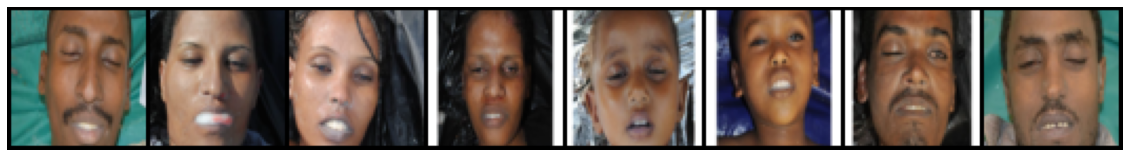

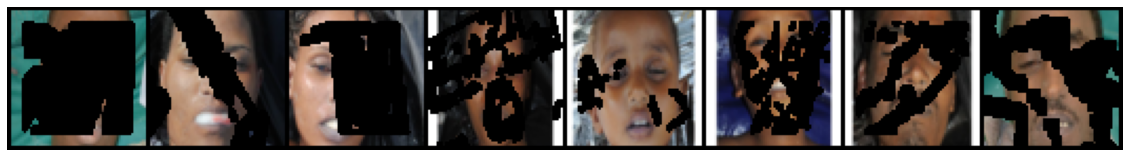

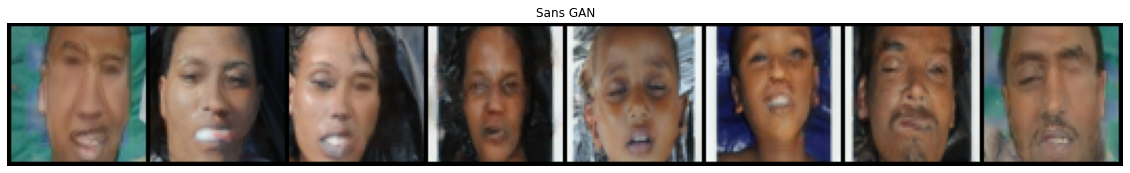

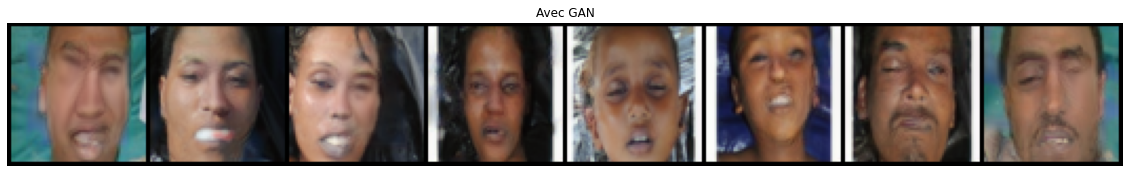

In [15]:
compareGAN("./modelSave/09_08/generator_low_fliplabel",seed=3)

## Stabilité GAN

### Normalisation OK

In [17]:
dataset = getTestData("./data/real",factorResize=1)
testloader = DataLoader(dataset, num_workers=2, batch_size=16, shuffle=False)
alter = imp.mask.Alter(resize=1,seed=0,test=True).irregularMask # squareMask irregularMask

# Sans GAN
model = imp.model.UNet(4, netType="partial").to(device) 
model.load_state_dict(torch.load("./modelSave/02_08/partial4channels_low"))
model.eval()


with torch.no_grad():
    x, _ = next(iter(testloader))
    x = x.to(device)
    segmented = get_segmentation(x, simplify=True, scale_factor=4)
    x_prime = alter(x)
    x_input = torch.cat((x_prime, segmented),dim=1)
    outputs = model(x_input)

    if (outputs[0] < 0).any() or ((outputs[0] > 1).any()) :
        print("output pas entre 0 et 1")
    else :
        print("output normalisé")

output normalisé


### Noise

In [10]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch

def addNoise(imgs,coef=0.1):
    imgs = imgs.cpu().detach().numpy()
    noise = np.random.normal(loc=0, scale=1, size=imgs.shape)
    noisy = np.clip((imgs + noise*coef),0,1)
    noisy = torch.from_numpy(noisy)
    noisy = noisy.to(device)
    return noisy.float()

0.08750000000000001
0.07500000000000001
0.0625
0.05
0.037500000000000006
0.024999999999999994
0.012499999999999997
0.0


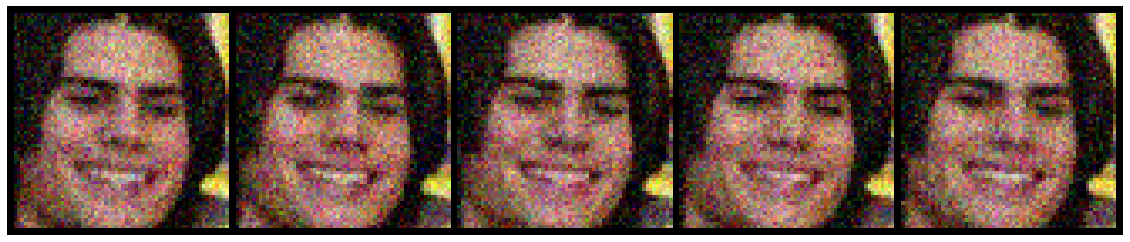

In [73]:
k = 8
for i in range(k):
    current_noise = 0.1/k*(i+1)
    current_noise = 0.1 - current_noise
    print(current_noise)
    
path = "./data/lfw/AJ_Lamas/AJ_Lamas_0001.jpg"
with Image.open(path) as img:
    resize = (120, 120)
    crop   = (64 , 64 )
    transformations = transforms.Compose([
         transforms.Resize(resize), 
         transforms.CenterCrop(crop),
         transforms.ToTensor()
    ])
    img = transformations(img)
    
    c,w,h = img.shape
    k=16
    imgs = torch.empty((5,c,w,h))
    imgs[0] = img.clone()
    imgs[1] = img.clone()
    imgs[2] = img.clone()
    imgs[3] = img.clone()
    imgs[4] = img.clone()
    imgs = addNoise(imgs)
    
    img_grid = make_grid(imgs)
    plt.figure(figsize=(20,15))
    plt.imshow(img_grid.cpu().permute(1, 2, 0))
    plt.axis('off')
    plt.show()


In [11]:
def train_context_encoder_noise(generator, discriminator, optimizerG, optimizerD, loader, alter, epochs=10, scale_factor=4, real_label=0.9, fake_label=0, show_images=True, maximumnoise=0.1):
    
    for epoch in range(epochs):
        t = tqdm(loader)
        current_noise = maximumnoise / epochs*(epoch+1)
        current_noise = maximumnoise - current_noise
        
        for x, _ in t:
            x = x.to(device)
            
            ## Train with all-fake batch
            segmented = get_segmentation(x, simplify=True, scale_factor=scale_factor)
            x_noise = addNoise(x,current_noise)
            x_prime = alter(x_noise)  
            x_input = torch.cat((x_prime, segmented),dim=1)
            fake = generator(x_input)

        # discriminator update
            errD, D_x, D_G_z1 = update_discriminator(discriminator, optimizerD, x, fake, real_label, fake_label)
            errG, D_G_z2 = update_generatot(generator, discriminator, optimizerG, x, fake, real_label)


        print(f'epoch:{epoch}/{epochs} \tLoss_D:{errD.item():.4f} \tLoss_G:{errG.item():.4f} \tD(x):{D_x:.4f} \tD(G(z)):{D_G_z1:.4f} / {D_G_z2:.4f} \nCurrent Noise: {current_noise}')
        if show_images:
            plot_img(x[:8])
            plot_img(x_noise[:8])
            plot_img(x_prime[:8])
            plot_img(segmented[:8])
            plot_img(torch.clip(fake[:8], 0, 1))

In [ ]:
real_label = 0.9
fake_label = 0.

discriminator.apply(weights_init);
generator = imp.model.UNet(4, netType="partial").to(device) 
generator.load_state_dict(torch.load("./modelSave/09_08/partial4channels_low"))
generator.eval()

# Setup Adam optimizers for both G and D
lr = 0.002
beta1 = 0.5
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr/10, weight_decay=0.001)

factorResize = 1
scale_factor = 4
trainloader, testloader = imp.data.getFaces(shuffle=True,resize=factorResize)
alter = imp.mask.Alter(resize=factorResize,seed=0,test=True).irregularMask # squareMask irregularMask

#discriminator.load_state_dict(torch.load("./modelSave/09_08/discriminator_low"))
#discriminator.eval()
#generator.load_state_dict(torch.load("./modelSave/09_08/generator_low"))
#generator.eval()

train_context_encoder_noise(generator, discriminator, optimizerG, optimizerD, trainloader, alter, epochs=23, scale_factor=scale_factor)
torch.save(generator.state_dict(),"./modelSave/09_08/generator_low_noise")
torch.save(discriminator.state_dict(),"./modelSave/09_08/discriminator_noise")

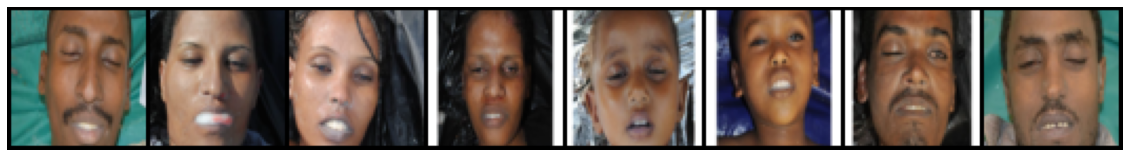

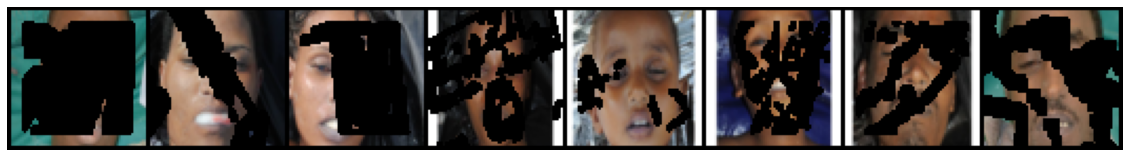

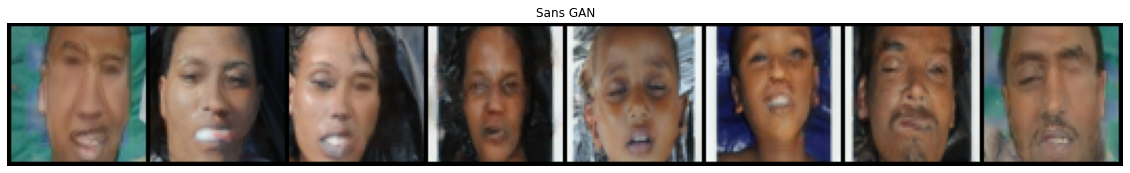

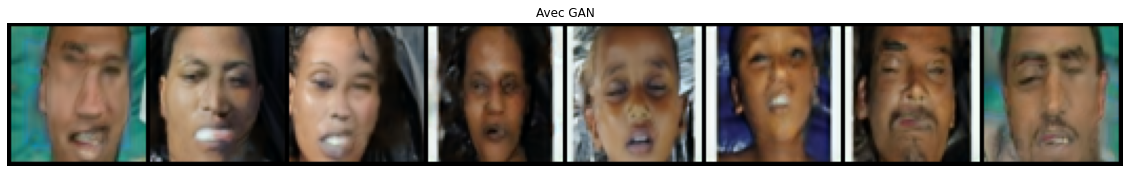

In [17]:
compareGAN("./modelSave/09_08/generator_low_noise",seed=3)

### Entrainer discriminateur +